# RAW DATA CONVERSION FROM TARGZ
Only uses the targz files without extracting the content.
This notebook takes the raw data fron the PAVNET VLF receiver and applies the FFT to get the spectrums, from these spectrums we track the target transmitters (VLF) and save these narrowband signals.

#### Notice
In the simplest (and best) case you only have to change the paths of data.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# add to path the additional modules implemented for PAVNET data analysis
sys.path.append("/home/aldo//notebooks/code")

# VLF TRANSMITTERS

In [2]:
vlf_transmitters = {
                    "NPM":21.4e3, 
                    "NAA":24.0e3, 
                    "NLK":24.8e3, 
                    "NLM":25.2e3,
                    "NAU":40.75e3
                    }

# Módulos

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import dates as mdates
import pandas as pd
from scipy import signal
from scipy.fftpack import fft, fftfreq, fftshift
from scipy.signal import firwin, lfilter
import time
import tools       # codigo propio
import datetime
import itertools
from IPython.display import clear_output
from io import StringIO as strio
import tarfile
import scipy.integrate as integrate

In [4]:
import gc
import fft_pavnet
gc.collect()

0

### Plot params

In [5]:
plt.rcParams["figure.figsize"] = [10,7.5]
plt.rcParams["font.size"] = 16

plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 2.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.minor.width'] = 2

plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.minor.width'] = 2

In [6]:
def butter_filt(s,cutoff, fs, order=5, fc=12e3):
    #return sp.signal.butter(order, cutoff, fs=fs, btype="low", analog=False)
    sos = sp.signal.butter(order, fc, btype='hp', fs=fs, output='sos')
    filtered = sp.signal.sosfilt(sos, s)
    return filtered

# Processing

## General parameters

In [7]:
sampling_freq = 50e3 # frecuencia de muestreo de la señal en la RedPitaya
Npts = 2**14  # signal length tamaño dela señal   
frames_per_file = 1  #signals per file
fft_npts = 2**12

MINSIZE_THRESHOLD = 80000 

In [8]:
folder1 = "/data/pavnet/2025/test_decaimiento_100-900mvpp/data/" # contains subfolders
# each subfolder contains a day of data
resfolder = '/'+"/".join(folder1.split("/")[:-2]) # path for outputs)
files = !ls $folder1
#subfolders

In [14]:
files

["ls: cannot access '/data/pavnet/2025/test_decaimiento_100-900mvpp/data/': No such file or directory"]

In [9]:
signal_len = Npts

method ="overlap" # window or overlap

fft_npts = 2**12

povlp = 50 # %

# frequency range (band). For f0(central frequency)=20 and bw=20, the resulting spectral will span from 10 to 30 
f0 = 25e3
bw = 40e3

# no guardar espectros para salvar memoria
SAVE_SPECTRUMS = True #False
downsampling_factor = 6 # 6 samples per minute

# trim signal length
# 2**14 ~ 16k
# 2**13 ~ 8k
# 2**12 ~ 4k

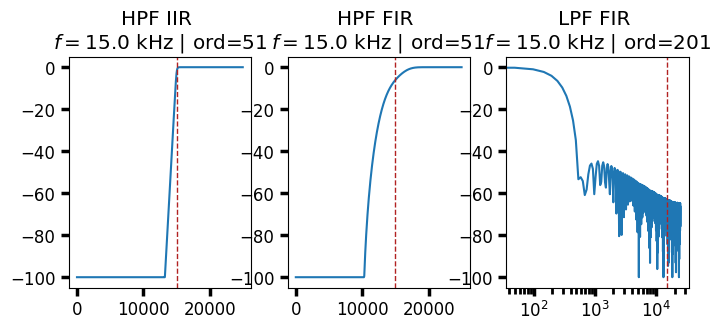

In [10]:
# HPF
order = 51
order0 = 201
fc = 15e3
fs = sampling_freq
sos = signal.butter(order, fc, btype='hp', fs=fs, output='sos')
hpf = signal.firwin(order, cutoff=15e3, window="flattop", fs=fs, pass_zero="highpass")
lpf_zero = firwin(order0, cutoff=100, fs=fs, pass_zero="lowpass")
#filtered = sp.signal.sosfilt(sos, s)
plt.rcParams["font.size"]=12

fig = plt.figure(figsize=(8,3))
plt.subplot(131)
w, h = signal.freqz_sos(sos, worN=1500, fs=fs)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w, db)
plt.axvline(fc, ls="--", lw=1, color="firebrick")
plt.title(f"HPF IIR \n$f={fc/1e3}$ kHz | ord={order}")

plt.subplot(132)
w, h = signal.freqz(hpf, fs=fs)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w, db)
plt.axvline(fc, ls="--", lw=1, color="firebrick")
plt.title(f"HPF FIR \n$f={fc/1e3}$ kHz | ord={order}")

plt.subplot(133)
w, h = signal.freqz(lpf_zero, fs=fs)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w, db)
plt.axvline(fc, ls="--", lw=1, color="firebrick")
plt.title(f"LPF FIR \n$f={fc/1e3}$ kHz | ord={order0}")
plt.xscale("log")

#plt.subplots_adjust(wspace=1)

In [11]:
def get_content(ftar):
    # obtener archivo de datos (TXT) contenido en el comprimido tar.gz
    tar= tarfile.open(ftar, "r:gz")
    fileout = tar.extractfile(tar.getmembers()[0])
    content = fileout.read()
    return content
    
def fft_method(st):
    #return fft_pavnet.fft_window(st, wlen=fft_npts,fw=signal.windows.flattop)
    return fft_pavnet.fft_overlap(st, wlen=fft_npts,fw=signal.windows.flattop)

def basebandiq(x, tt, fc, bw=100, fs=50e3):
    xi = np.cos(2*np.pi*fc*tt)  * x
    xq = -np.sin(2*np.pi*fc*tt) * x
    lpf = firwin(101, cutoff=bw, fs=fs)
    xi = signal.filtfilt(lpf, 1, xi)
    xq = signal.filtfilt(lpf, 1, xq)

    return xi, xq

def IQ_clipping_filter(iq, nstd=None):
    #clip_min, clip_max = np, 1.0
    if not nstd: nstd = 3
    ithr = nstd * np.std(iq[:, 0])
    qthr = nstd * np.std(iq[:, 1])
    I_clipped = np.clip(iq[:,0], -ithr, ithr)
    Q_clipped = np.clip(iq[:,1], -qthr, qthr)
    return I_clipped, Q_clipped

In [12]:
hpf = signal.firwin(51, cutoff=12e3, window="hamming", fs=sampling_freq)

In [13]:
time_arr = []
fftv =[]
amplitudes_bb = {tx:[] for tx in vlf_transmitters.keys()}
amplitudes_2 = {tx:[] for tx in vlf_transmitters.keys()}
amplitudes_3 = {tx:[] for tx in vlf_transmitters.keys()}
freq_arr = np.arange(fft_npts)*sampling_freq/fft_npts
freq_arr_all = np.arange(signal_len)*sampling_freq/signal_len

ftx_indexhood = []
bw = 100 

hpf = signal.firwin(51, cutoff=12e3, window="hamming", fs=sampling_freq)
N = 1
ti = time.time()
for call, f in vlf_transmitters.items():
    i = np.argmin(abs(freq_arr-f))
    id_0 = np.argmin(abs(freq_arr-(f-bw/2)))
    id_f = np.argmin(abs(freq_arr-(f+bw/2)))
    ftx_indexhood.append([id_0, id_f])
fc = 24e3
t = np.arange(signal_len)/fs

cutoff = 100  # Hz (ancho de banda útil)
numtaps = 101
lpf = firwin(numtaps, cutoff=cutoff, fs=fs)
nfiles= len(files)
for k, f in enumerate(files[:]):
#print(f"File {f}\t {k+1} of {nfiles} processed \t -> {round((k+1)*100/nfiles, 2)} %",end="\r")
    print("File {:60s}\t {:7d} of {:7d} processed \t -> {:3.2f} %".format(f,k+1, nfiles, round((k+1)*100/nfiles, 2) ),end="\r")
    content = get_content(folder1+"/"+f)
    st = pd.read_csv(strio(content.decode()), comment="#", header=None, sep=",").values
    #filtered = sp.signal.sosfilt(sos, s)
    #st = signal.sosfilt(sos,st.values[:,0]) + 1j*signal.sosfilt(sos,st.values[:,1])  # signal IQ fmt
    [st[:,0] , st[:,1]] = IQ_clipping_filter(st)
    
    iq = signal.filtfilt(hpf, 1, st[:,0]) +1j*signal.filtfilt(hpf, 1, st[:,1])
    sc_baseband = iq * np.exp(-1j * 2 * np.pi * fc * t)
    shifted_filtered_real = lfilter(lpf_zero, 1.0, sc_baseband.real)
    shifted_filtered_imag = lfilter(lpf_zero, 1.0, sc_baseband.imag)
    envelope = shifted_filtered_real + 1j * shifted_filtered_imag
    
    # 3. Amplitud
    amplitude = np.abs(envelope)
    #fftv.append(amplitude)
    #st = signal.filtfilt(hpf,1,st.values[:,0]) + 1j*signal.filtfilt(hpf,1,st.values[:,1])
    # almaecnamos el tiempo en UTC : +5h
    time_arr.append(tools.get_date_from_fname(str(f)) + datetime.timedelta(hours=5))
    #print("\napplying FFT {}".format(method))
    S = fft_method(iq) #fft_pavnet.fft_window(st, wlen=fft_npts,fw=signal.windows.flattop)
    S_all = fft_pavnet.fft_window(iq, fft_npts=Npts, ret_freq=False)
    
    #if method == "single":
    #    S = fft_pavnet.fft_window(st, wlen=fft_npts,fw=signal.windows.flattop)
    #elif method == "overlap":
    #    S = fft_pavnet.fft_overlap(st, wlen=fft_npts, wfun=signal.windows.hann, povlp=povlp)
    #else:
    #    break
    #Savg += S
    #if SAVE_SPECTRUMS and not k%6:
        
    #    fftv.append(Savg/6)
    #    Savg = np.zeros(fft_npts)
    
    for k, (tx_call, tx_f) in enumerate(vlf_transmitters.items()):
        #id_0, id_f = ftx_indexhood[k]
        #wf = freq_arr[id_0:id_f]
        #amp_ = integrate.simpson(S[id_0:id_f], wf)
        #amp_2 = max(S[id_0:id_f])
        #amplitudes[tx_call].append(amp_)
        #amplitudes_2[tx_call].append(amp_2)
        mask = (freq_arr_all>=tx_f-bw/2) & (freq_arr_all<=tx_f+bw/2)
        ampw = integrate.simpson(S_all[mask], freq_arr_all[mask])
        amplitudes_3[tx_call].append(ampw)
    
        xi, xq = basebandiq(iq.real,t, tx_f)
        ai, aq = integrate.simpson(xi, t), integrate.simpson(xq, t)
        amplitudes_bb[tx_call].append(np.sqrt(ai**2 + aq**2))
        
print("\n---") 

print(f"Total processing time: {time.time()-ti} s")

File ls: cannot access '/data/pavnet/2025/test_decaimiento_100-900mvpp/data/': No such file or directory	       1 of       1 processed 	 -> 100.00 %

FileNotFoundError: [Errno 2] No such file or directory: "/data/pavnet/2025/test_decaimiento_100-900mvpp/data//ls: cannot access '/data/pavnet/2025/test_decaimiento_100-900mvpp/data/': No such file or directory"

In [18]:
ampdf3 = pd.DataFrame(amplitudes_3,index=time_arr)/Npts
ampdf3.sort_index(inplace=True)

<Axes: >

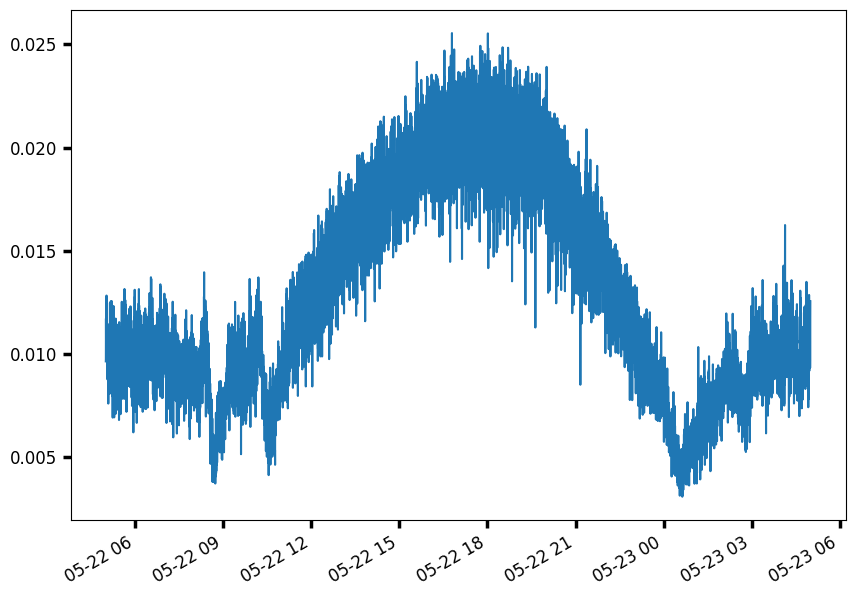

In [19]:
ampdf3["NAA"].plot()

<Axes: >

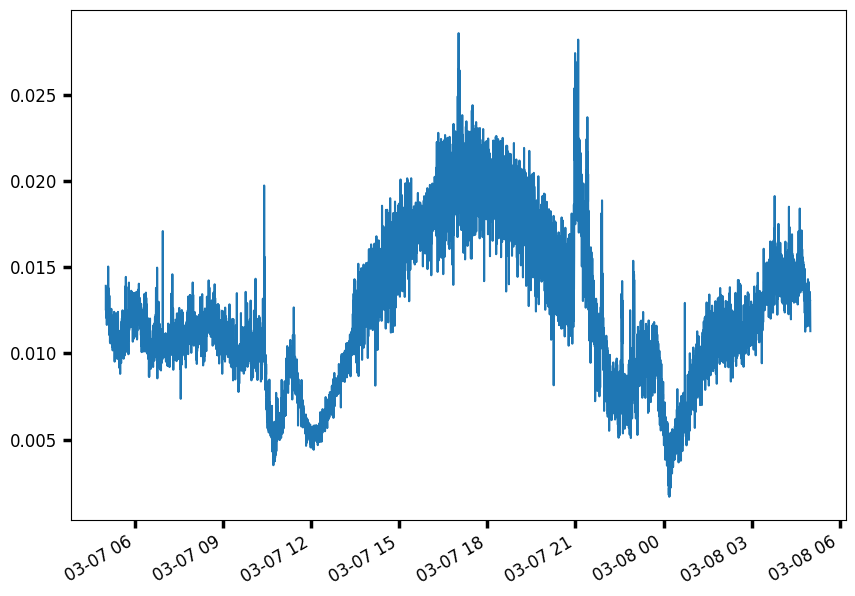

In [62]:
ampdf3["NAA"].plot()

<Axes: >

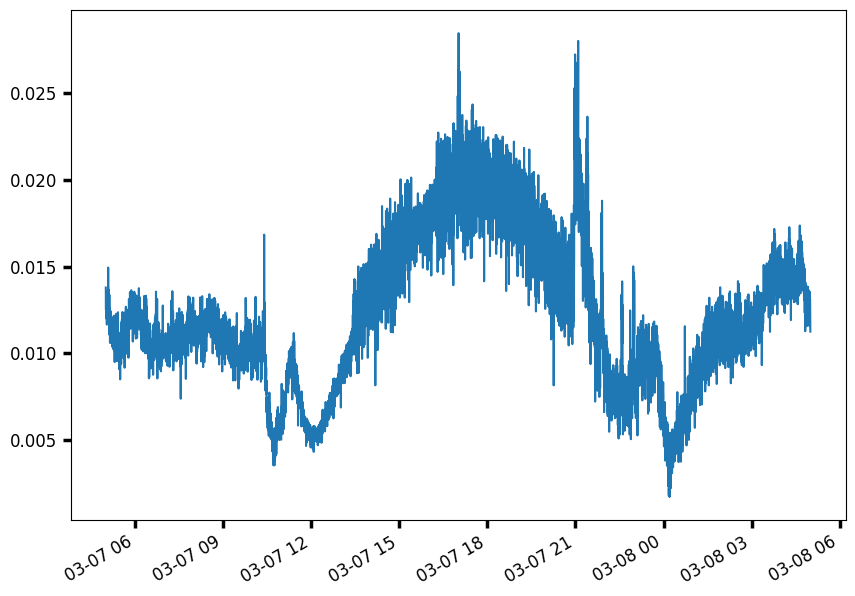

In [72]:
ampdf3["NAA"].plot()

## Testing

In [132]:
lowp = signal.firwin(101, 0.01, fs=1/10)
ampdf["NAA-filt"] = signal.filtfilt(lowp, 1, ampdf["NAA"].values)
ampdf2["NAA-filt"] = signal.filtfilt(lowp, 1, ampdf2["NAA"].values)
ampdf3["NAA-filt"] = signal.filtfilt(lowp, 1, ampdf3["NAA"].values)

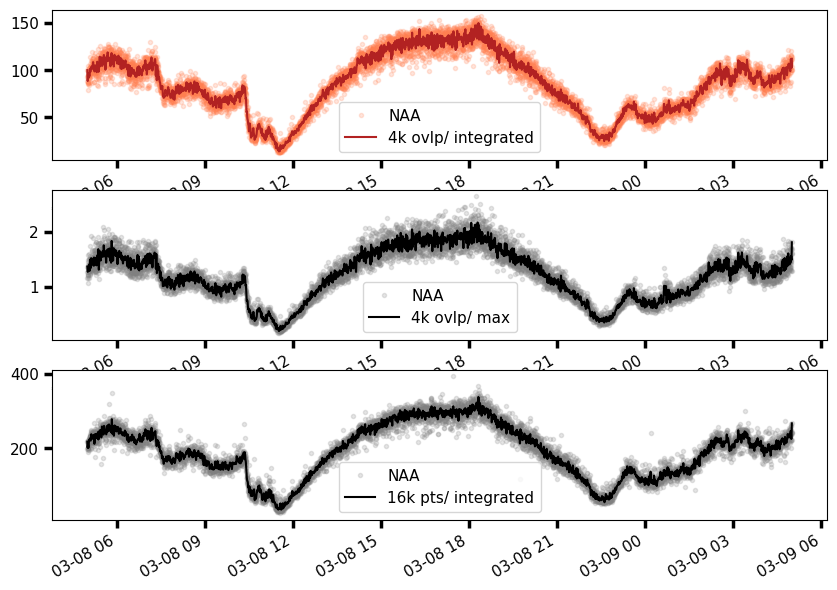

In [134]:
ax = plt.subplot(311)
ampdf["NAA"].plot(alpha=0.2, color="coral", ax=ax, marker=".",lw=0)
ampdf["NAA-filt"].plot( color="firebrick", ax=ax, label="4k ovlp/ integrated")
ax.legend()
ax2 = plt.subplot(312)#ax.twinx()
ampdf2["NAA"].plot(color="gray", alpha=0.2,ax=ax2, marker=".", lw=0)
ampdf2["NAA-filt"].plot( color="black", ax=ax2, label="4k ovlp/ max")
ax2.legend()
ax2 = plt.subplot(313)#ax.twinx()
ampdf3["NAA"].plot(color="gray", alpha=0.2,ax=ax2, marker=".", lw=0)
ampdf3["NAA-filt"].plot( color="black", ax=ax2, label="16k pts/ integrated")
ax2.legend()

(20000.0, 25000.0)

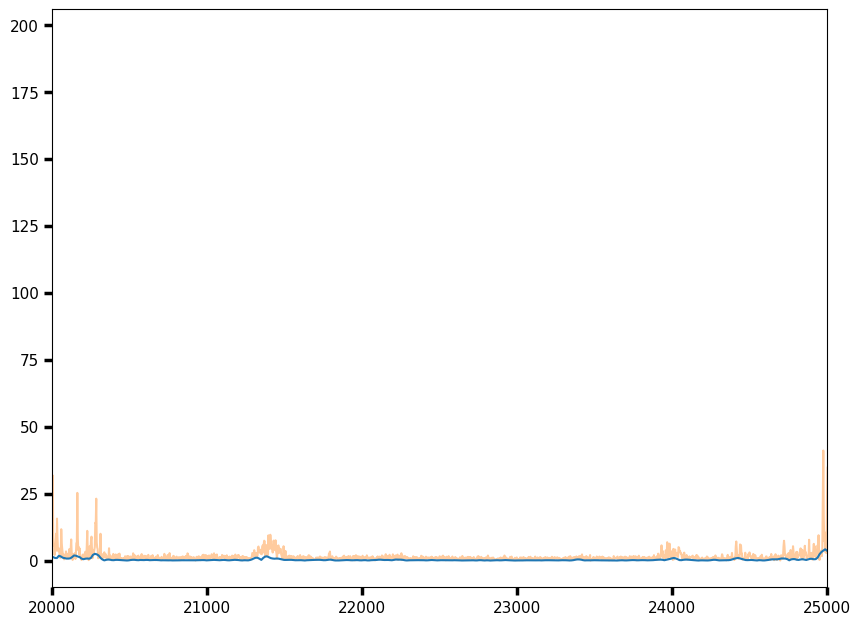

In [87]:
S16 = abs(fftshift(fft(iq)))
freq_16 = np.arange(len(iq))*sampling_freq/len(iq)
plt.plot(freq_arr, S, zorder=1)
plt.plot(freq_16, S16, alpha=0.4,zorder=0)
plt.xlim(20e3,25e3)

In [82]:
waan4 = S[(23.9e3<freq_arr) & (24.1e3>freq_arr)]
waan16 = S16[(23.9e3<freq_16) & (24.1e3>freq_16)]
x4 = freq_arr[(23.9e3<freq_arr) & (24.1e3>freq_arr)]
x16 = freq_16[(23.9e3<freq_16) & (24.1e3>freq_16)]

In [84]:
I4 = integrate.simpson(waan4, x=x4)
I16 = integrate.simpson(waan16, x=x16)
print(I4/200, I16/200)

1.062658074271311 4.743330410220605


## Time series amp data

In [19]:
ampdf3.head()

,NPM,NAA,NLK,NLM,NAU
2025-03-06 17:00:21,0.007152,0.018272,0.005689,0.004439,7.990518e-08
2025-03-06 17:00:31,0.007400,0.019113,0.004221,0.004006,7.013460e-08
2025-03-06 17:00:41,0.007504,0.020774,0.003789,0.003724,8.467396e-08
2025-03-06 17:00:51,0.006862,0.020583,0.003879,0.004133,9.706704e-08
2025-03-06 17:01:01,0.007454,0.018598,0.003951,0.004665,7.203769e-08


In [23]:
lowp = signal.firwin(101, 0.005, fs=1/10)
for i, tx in enumerate(ampdf3.keys()):
    ampdf3[f"{tx}-filt"] = signal.filtfilt(lowp, 1, ampdf3[tx].values)

<Axes: >

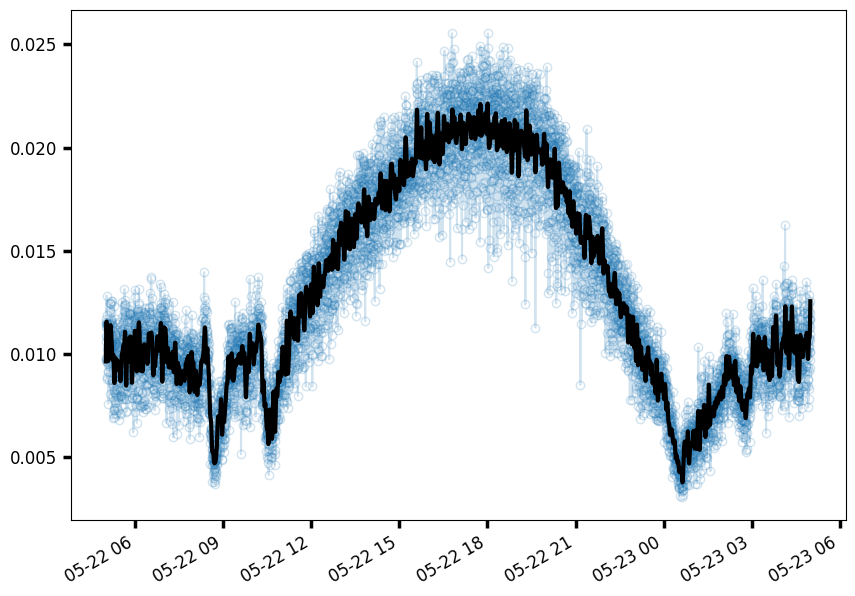

In [29]:
ampdf3["NAA"].plot(marker="o", markerfacecolor="none",alpha=0.2)
ampdf3["NAA-filt"].plot(color="black",lw=3)

In [48]:
ampdf3.to_csv(f"/home/aldo/notebooks/amplitude/PIU_AMPLITUDE_{ampdf3.index[0].date()}-to-{ampdf3.index[-1].date()}.csv",)

In [56]:
timev = sorted(time_arr)

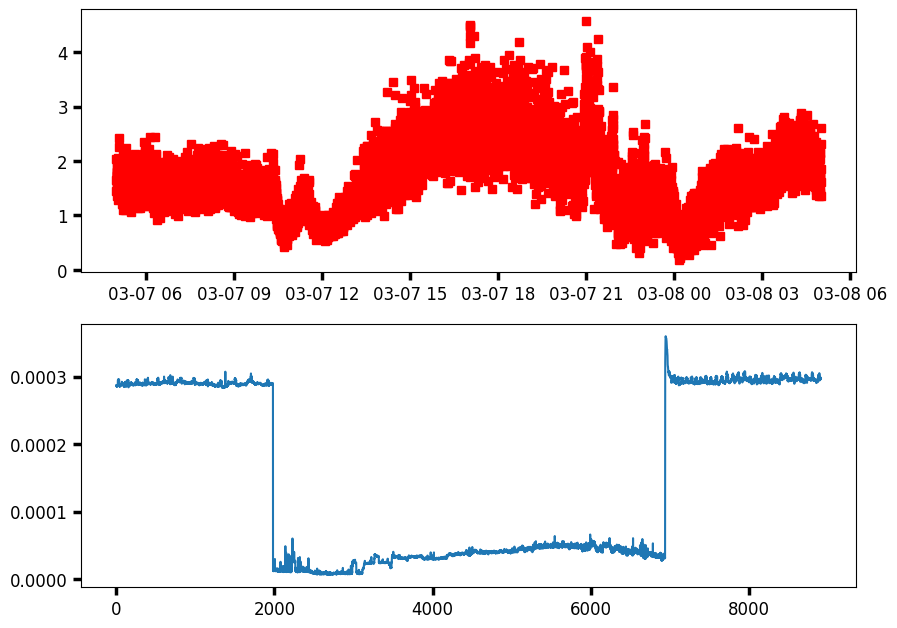

In [61]:
plt.subplot(211)
plt.plot(ampdf["NAA"], "sr")

plt.subplot(212)
plt.plot(amp_naa)


m1: -2.6165771484367795e-07
m2: 0.00021766619873046886


(0.0, 1050.0)

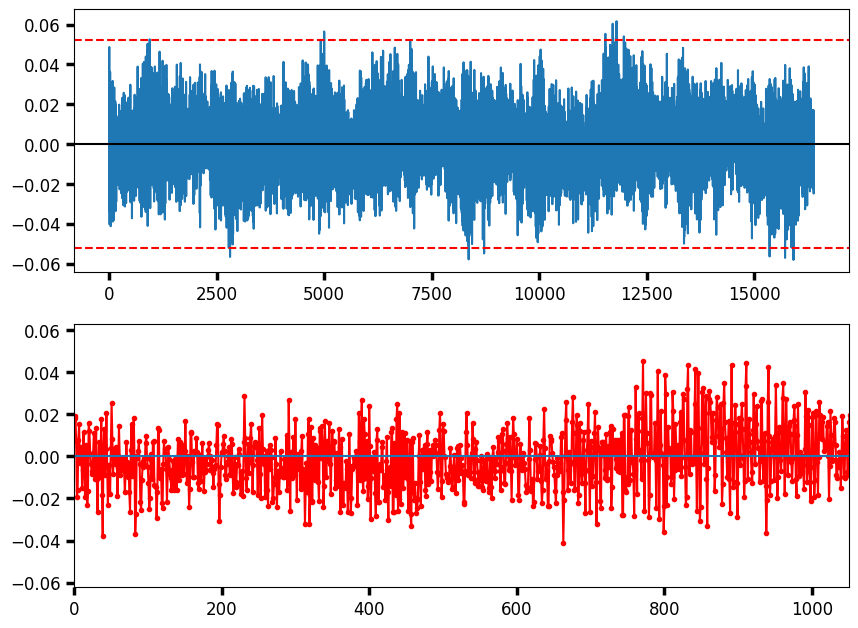

In [75]:
s = pd.read_csv(strio(content.decode()), comment="#", header=None, sep=",").values
plt.subplot(211)
plt.plot(s[:,0])
m1 =np.mean(s[:, 0])
s1 = np.std(s[:, 0])
print(f"m1: {m1}")
plt.axhline(m1, color="k")
plt.axhline(3.5*s1, color="r", ls="--")
plt.axhline(-3.5*s1, color="r", ls="--")
#plt.xlim(4700, 4850)
plt.subplot(212)
plt.plot(s[:,1],"-r.")
m2 =np.mean(s[:,1])
print(f"m2: {m2}")
plt.axhline(np.mean(s[:,1]))
plt.xlim(0, 1050)

(0.0, 10.0)

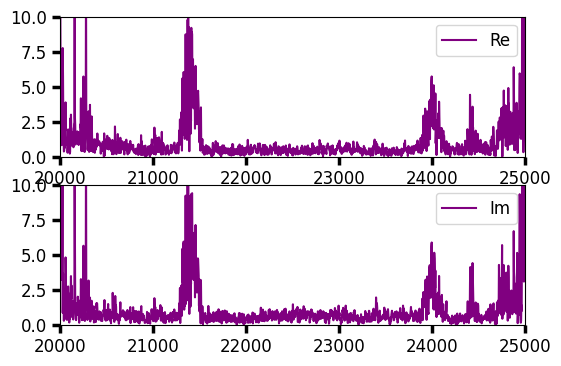

In [27]:
Xre = (fft(s[:,0]))
Xim = (fft(s[:,1]))
fri = fftshift(fftfreq(len(s[:,1]), 1/fs))
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(211)
plt.plot(fri, abs(Xre), label="Re", color="purple")

plt.legend()
plt.subplot(212, sharex=ax, sharey=ax)
plt.plot(fri, abs(Xim), label="Im", color="purple")
plt.legend()
plt.xlim(20e3, 25e3)
plt.ylim(0,10)

(0.0, 10.0)

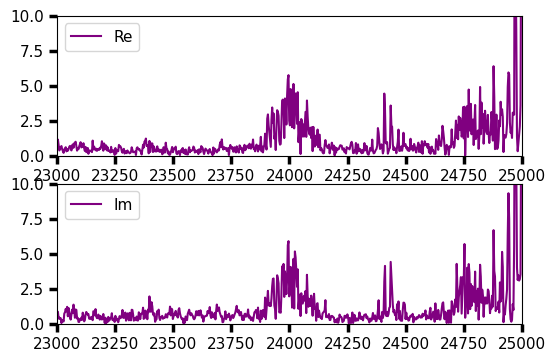

In [70]:
#hpf = signal.firwin(51, cutoff=15e3, window="hamming", fs=sampling_freq, pass_zero="highpass")
Xre_filt = fft(signal.filtfilt(hpf, 1, s[:,0]))
Xim_filt = fft(signal.filtfilt(hpf, 1, s[:,1]))
fri = fftshift(fftfreq(len(s[:,1]), 1/fs))

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(211)
plt.plot(fri, abs(Xre_filt), label="Re", color="purple")

plt.legend()
plt.subplot(212, sharex=ax, sharey=ax)
plt.plot(fri, abs(Xim_filt), label="Im", color="purple")
plt.legend()
plt.xlim(23e3, 25e3)
plt.ylim(0,10)

In [60]:
frre = np.arange(len(fri))*sampling_freq/len(fri)
fri

array([-25000.        , -24996.94824219, -24993.89648437, ...,
        24990.84472656,  24993.89648437,  24996.94824219], shape=(16384,))

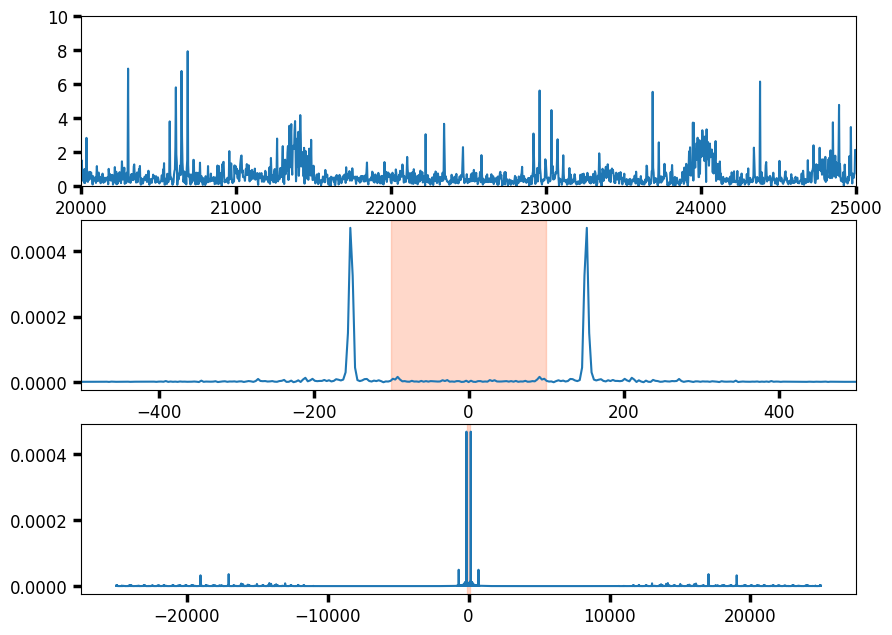

In [60]:
x = s[:,0]
x = signal.lfilter(hpf, 1, x)
tt = np.arange(0, len(s[:, 0]))*1/sampling_freq
xi = np.cos(2*np.pi*fc*tt)  * x
xq = -np.sin(2*np.pi*fc*tt) * x
f = fftshift(fftfreq(len(x), 1/sampling_freq))
plt.subplot(311)
plt.plot(f, abs(fft(x)))
plt.xlim(20e3, 25e3); plt.ylim(0,10)

cutoff = 150  # Hz (ancho de banda útil)
numtaps = 101
lpf = firwin(numtaps, cutoff=cutoff, fs=fs)
xi = signal.filtfilt(lpf, 1, xi)
xq = signal.filtfilt(lpf, 1, xq)
plt.subplot(312)
plt.plot(f, fftshift(abs(fft(xi*signal.windows.hann(len(xi))))))
plt.axvspan(-100,100, alpha=0.3,color="coral")
plt.xlim(-500, 500); 
#plt.ylim(0,10)
plt.subplot(313)
plt.plot(f, fftshift(abs(fft(xq*signal.windows.hann(len(xi))))))
#plt.xlim(20e3, 25e3); plt.ylim(0,10)
plt.axvspan(-100,100, alpha=0.3,color="coral")

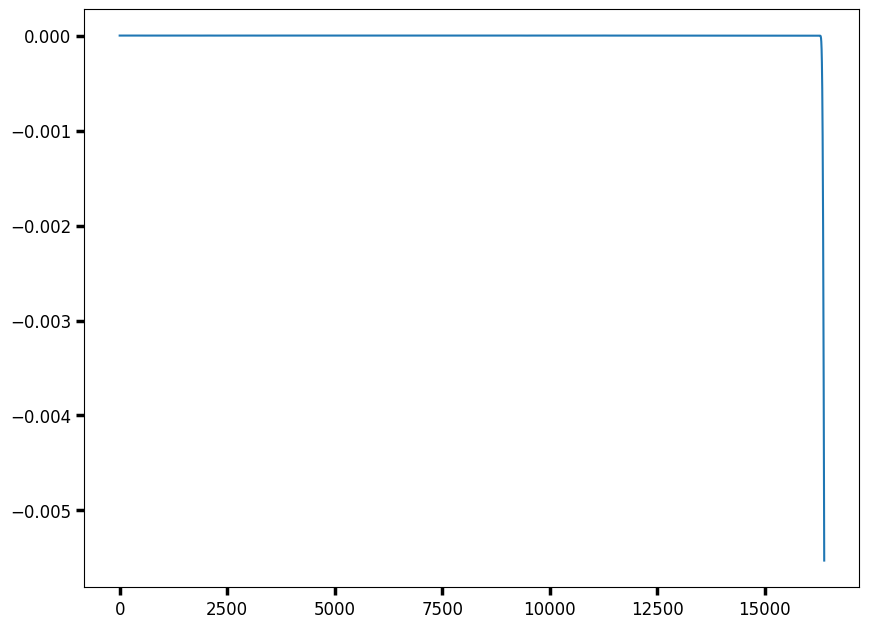

In [61]:
plt.plot(xi)

In [37]:
def basebandiq(x, tt, fc, bw=100, fs=50e3):
    xi = np.cos(2*np.pi*fc*tt)  * x
    xq = -np.sin(2*np.pi*fc*tt) * x
    lpf = firwin(101, cutoff=bw, fs=fs)
    xi = signal.filtfilt(lpf, 1, xi)
    xq = signal.filtfilt(lpf, 1, xq)

    return xi, xq

24000.0

<figure style="text-align: left;">
  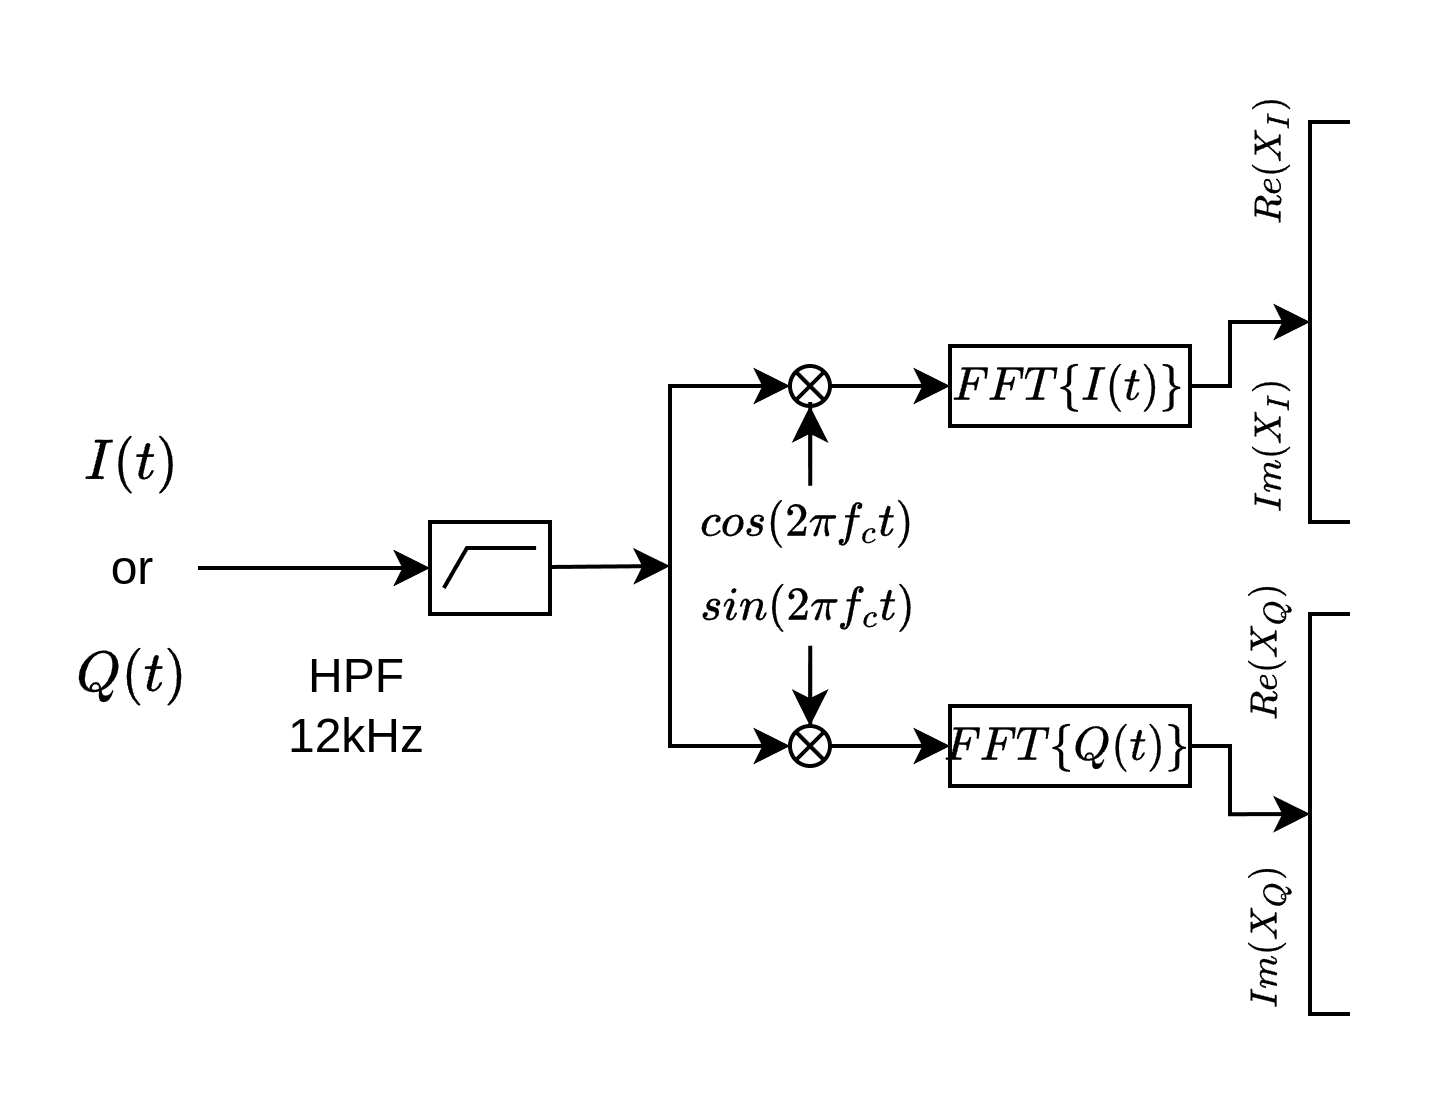
  <figcaption>Figura 1: Intento de IQ a baseband for amp calciulation</figcaption>
</figure>

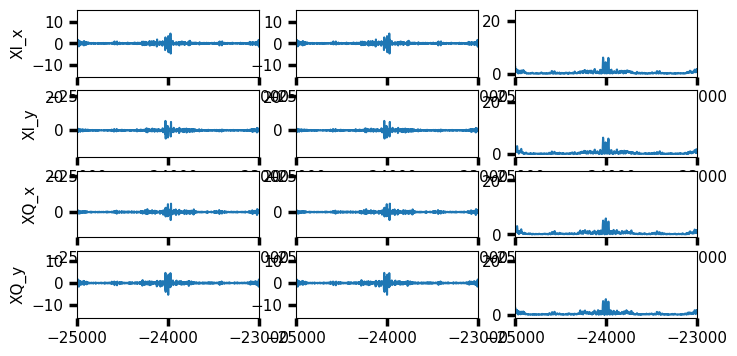

In [69]:
#hpf = signal.firwin(51, cutoff=15e3, window="hamming", fs=sampling_freq, pass_zero="highpass")
tt = np.arange(0, len(s[:, 0]))*1/sampling_freq
fc =24e3
slen = len(s[:, 0])

#signal_bb = signal * np.exp(-1j*2*np.pi*fc*t)
ssI_x = signal.filtfilt(hpf, 1, s[:,0])*signal.windows.hann(slen)*np.cos(2*np.pi*fc*tt)
ssI_y = signal.filtfilt(hpf, 1, s[:,0])*signal.windows.hann(slen)*np.sin(2*np.pi*fc*tt)
ssQ_x = signal.filtfilt(hpf, 1, s[:,1])*signal.windows.hann(slen)*np.cos(2*np.pi*fc*tt)
ssQ_y = signal.filtfilt(hpf, 1, s[:,1])*signal.windows.hann(slen)*np.sin(2*np.pi*fc*tt)
#Xre_filt_I = fftshift(fft(ss_re) )
#Xre_filt_Q = fftshift(fft(ss_re) )
#ss_re_nb = signal.filtfilt(lpf, 1, ss_re) 
#ss_im_nb = signal.filtfilt(lpf, 1, ss_im)
XI_x = fftshift(fft( ssI_x))
XI_y = fftshift(fft( ssI_y))
XQ_x = fftshift(fft( ssQ_x))
XQ_y = fftshift(fft( ssQ_y))
Xtot_arr = [XI_x, XI_y, XQ_x, XQ_y]
names = ["XI_x", "XI_y" ,"XQ_x" , "XQ_y"]
fig = plt.figure(figsize=(8,4))
plt.rcParams["font.size"] =11
for k, X in enumerate(Xtot_arr):
    ax = plt.subplot(4,3,k*3+1)
    plt.plot(fri, X.real, label="Re"); plt.ylabel(names[k])
    plt.subplot(4,3,k*3+2, sharex=ax)
    plt.plot(fri, X.real, label="Im")
    plt.subplot(4,3,k*3+3, sharex=ax)
    plt.plot(fri, abs(X), label="|·|")
    ax.set_xlim(-25e3, -23e3)


<figure style="text-align: left;">
  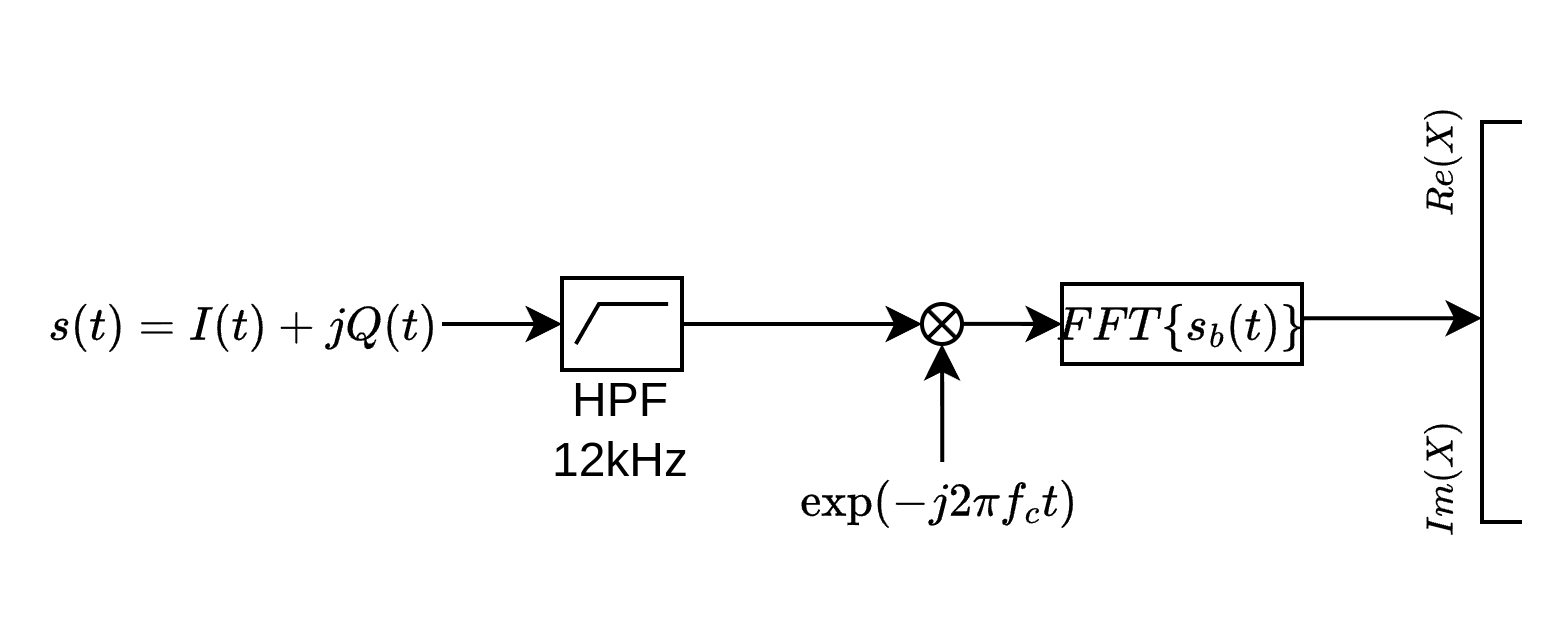
  <figcaption>Figura 1: Intento de IQ a baseband for amp calciulation</figcaption>
</figure>

In [37]:
#hpf = signal.firwin(51, cutoff=15e3, window="hamming", fs=sampling_freq, pass_zero="highpass")
tt = np.arange(0, len(s[:, 0]))*1/sampling_freq
fc =24e3
slen = len(s[:, 0])

b, a = signal.butter(15, 200, btype='low',fs=sampling_freq)
zi_I = np.zeros(max(len(a), len(b)) - 1)  # Estado inicial del filtro (I)
zi_Q = np.zeros(max(len(a), len(b)) - 1)

signal_bb = s[:,0] * np.exp(-1j*2*np.pi*fc*tt)
ssI = signal.filtfilt(hpf, 1, s[:,0]) #*signal.windows.hann(slen)*np.cos(2*np.pi*fc*tt)
#ssI_y = signal.filtfilt(hpf, 1, s[:,0])*signal.windows.hann(slen)*np.sin(2*np.pi*fc*tt)
ssQ = signal.filtfilt(hpf, 1, s[:,1]) #*signal.windows.hann(slen)*np.cos(2*np.pi*fc*tt)
#sQ_y = signal.filtfilt(hpf, 1, s[:,1])*signal.windows.hann(slen)*np.sin(2*np.pi*fc*tt)
#Xre_filt_I = fftshift(fft(ss_re) )
#Xre_filt_Q = fftshift(fft(ss_re) )
#ss_re_nb = signal.filtfilt(lpf, 1, ss_re) 
#ss_im_nb = signal.filtfilt(lpf, 1, ss_im)

st = ssI + 1j*ssQ
st_bb = st* np.exp(1j*2*np.pi*fc*tt)
st_bb_filt, zi = signal.lfilter(b, a,st_bb, zi=zi_I)



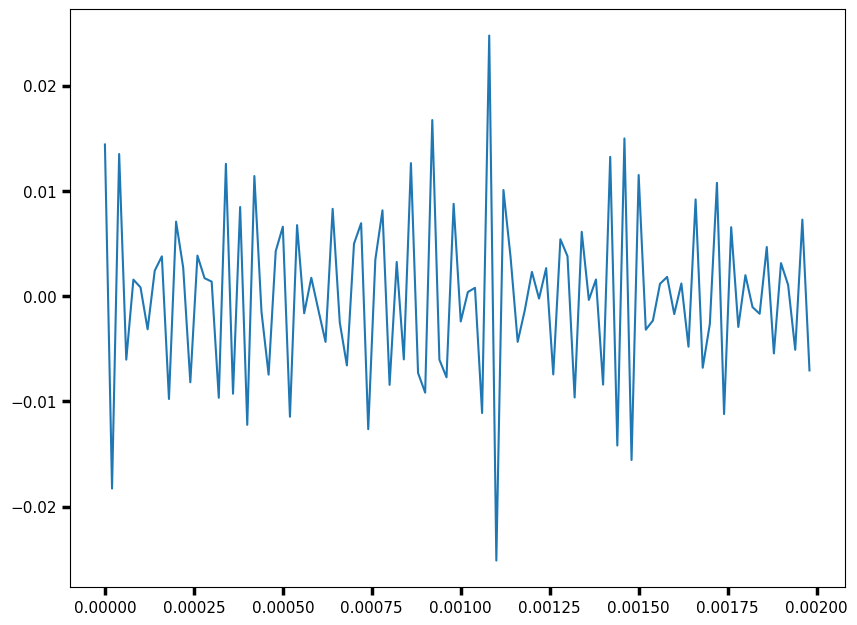

In [43]:
plt.plot(tt[:100], st_bb[:100])

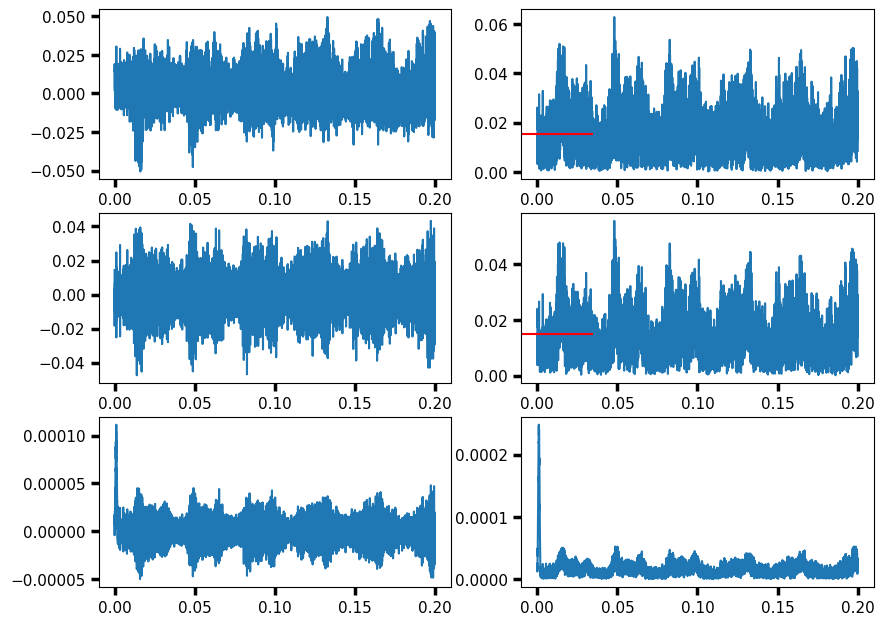

In [57]:
numtaps = 101
n = 10000
lpf = firwin(numtaps, cutoff=200, fs=fs)
st_bb_filt = signal.lfilter(lpf,  1,st_bb.real) + 1j*signal.lfilter(lpf,  1,st_bb.imag)

plt.subplot(321)
plt.plot(tt[:n], s[:n,0])
plt.subplot(322)
plt.plot(tt[:n], abs(s[:n,0]+1j*s[:n,1])), plt.axhline(np.mean(abs(s[:n,0]+1j*s[:n,1])), tt[0],tt[n], color="red") 
plt.subplot(323)
plt.plot(tt[:n], st_bb[:n])

plt.subplot(324)
plt.plot(tt[:n], abs(st_bb[:n])), plt.axhline(np.mean(abs(st_bb[:n])), tt[0],tt[n], color="red") 
plt.subplot(325)
plt.plot(tt[:n], st_bb_filt[:n])
plt.subplot(326)
plt.plot(tt[:n], abs(st_bb_filt[:n]))

In [ ]:
nn=len(timex)
fmin = 18e3
fmax = 30e3
fmask = (freq_arr>fmin) & (freq_arr<fmax)
fig = plt.figure(figsize=(10,5))
plt.pcolormesh(timex[:nn], freq_arr[fmask]/1e3, spectrogram.T[fmask, 0:nn], shading="gouraud")
plt.xlabel("Time")
plt.ylabel("Frequency (kHz)")

fig.savefig(f"PIU_Spectrum_{timex[nn].date()}-to-{timex[nn].date()}.png")
plt.close()

IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x72e3cbf3a840> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
del fig
gc.collect()

In [41]:
data = pd.DataFrame(amplitudes, index=time_arr)
data.sort_index(inplace=True)

In [42]:
data.head()

,NPM,NAA,NLK,NLM,NAU
2025-03-06 17:00:21,0.777341,1.692320,0.609361,0.579795,0.000009
2025-03-06 17:00:31,0.767992,1.795934,0.647088,0.483911,0.000009
2025-03-06 17:00:41,0.665142,1.932618,0.695498,0.521984,0.000010
2025-03-06 17:00:51,0.689199,1.946766,0.749937,0.483139,0.000010
2025-03-06 17:01:01,0.782117,1.971022,0.788177,0.484273,0.000008


(np.float64(20154.0), np.float64(20155.0))

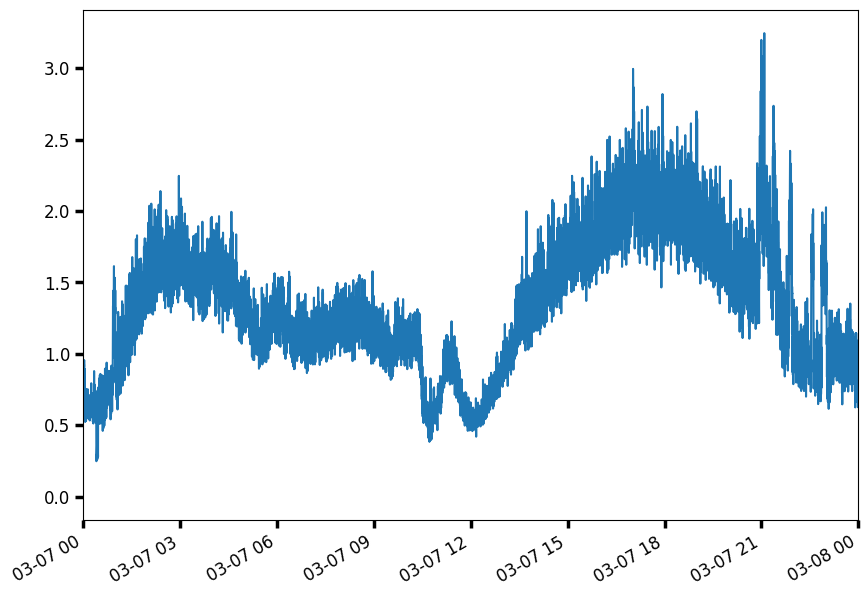

In [43]:
data["NAA"].plot()
plt.xlim(datetime.datetime(2025,3,7), datetime.datetime(2025,3,8))

In [47]:
data.index[0].date()

datetime.date(2025, 3, 6)

In [58]:
data.to_csv(f"/home/aldo/notebooks/amplitude/PIU_AMPLITUDE_{data.index[0].date()}-to-{data.index[-1].date()}.csv",)

In [82]:
data

,NPM,NAA,NLK,NLM,NAU
2025-03-06 17:00:21,0.777341,1.692320,0.609361,0.579795,0.000009
2025-03-06 17:00:31,0.767992,1.795934,0.647088,0.483911,0.000009
2025-03-06 17:00:41,0.665142,1.932618,0.695498,0.521984,0.000010
2025-03-06 17:00:51,0.689199,1.946766,0.749937,0.483139,0.000010
2025-03-06 17:01:01,0.782117,1.971022,0.788177,0.484273,0.000008
...,...,...,...,...,...
2025-03-20 04:59:03,3.426383,1.033131,0.745427,0.255756,0.000007
2025-03-20 04:59:13,3.637482,0.922008,0.749818,0.209257,0.000008
2025-03-20 04:59:22,3.242866,0.799884,0.734023,0.174850,0.000006
2025-03-20 04:59:32,3.231744,1.025667,0.706682,0.170995,0.000005


In [148]:
dfnaa = data.copy() #{"timestamp": time_arr, "value": values})

dfnaa["date"] = data.index.date
dfnaa["hour"] = data.index.hour + data.index.minute / 60 + data.index.second / 3600

pivot_table = dfnaa.pivot(index="date", columns="hour", values="NAA")

print(pivot_table)

hour        0.000278   0.002222   0.003056   0.005000   0.005833   0.007778   \
date                                                                           
2025-03-06        NaN        NaN        NaN        NaN        NaN        NaN   
2025-03-07   0.829715        NaN   0.855188        NaN   0.933057        NaN   
2025-03-08        NaN   0.706953        NaN   0.723478        NaN   0.768447   

hour        0.008611   0.010556   0.011111   0.013056   ...  23.986944  \
date                                                    ...              
2025-03-06        NaN        NaN        NaN        NaN  ...   0.757151   
2025-03-07   0.888907        NaN   0.822583        NaN  ...        NaN   
2025-03-08        NaN    0.70103        NaN   0.595147  ...        NaN   

hour        23.988889  23.989722  23.991667  23.992222  23.994167  23.995000  \
date                                                                           
2025-03-06        NaN   0.762315        NaN   0.833671        NaN   

In [94]:
st_ = pd.read_csv(strio(content.decode()), comment="#", header=None, sep=",")
st_ = st_.values[:,0] + 1j*st_.values[:,1]

In [179]:
lpf = signal.firwin(101, 0.005, fs=1/10, pass_zero="lowpass")

data_filtered = pd.DataFrame(index=data.index.values)

for tx in vlf_transmitters.keys():
    ti = time.time()
    amp_filt = signal.filtfilt(lpf,1,data[tx].values)
    data_filtered[tx+"_filt"] = amp_filt
    tf = time.time()
    print("etime: ", 1000*(tf-ti), "ms")

etime:  9.681940078735352 ms
etime:  9.987354278564453 ms
etime:  9.11855697631836 ms
etime:  9.000539779663086 ms
etime:  8.951902389526367 ms


In [ ]:
import matplotlib as mpl

In [225]:
cmap = mpl.colormaps['jet']
nplots = np.arange(1,14,2)
cgrads = cmap(np.linspace(0.1,0.9,len(nplots)))

In [148]:

d1 = datetime.datetime(2025,3,7)
d2 = d1 + datetime.timedelta(days=1)
sample_db = 20*np.log10(data["NAA"].loc[d1:d2])
sample_db_filt = 20*np.log10(data_filtered["NAA_filt"].loc[d1:d2])
off = 0
nplots = np.arange(1,14,2)
cgrads = cmap(np.random.rand(len(nplots)))
for k,i in enumerate(nplots):
    d1 = datetime.datetime(2025,3,i+6)
    d2 = d1 + datetime.timedelta(days=1)
    sample_db = 20*np.log10(data["NAA"].loc[d1:d2])
    sample_db_filt = 20*np.log10(data_filtered["NAA_filt"].loc[d1:d2])
    n = len(sample_db)
    plt.plot(np.arange(n)*24/n,sample_db.values + off, marker="o", markerfacecolor="none", color="lightgray", alpha=0.5)
    plt.plot(np.arange(n)*24/n,sample_db_filt.values + off,color=cgrads[k], lw=2, label=d1)
    off += 20
plt.legend(bbox_to_anchor=[1,1])
plt.title(f"PIU VLF ")

NameError: name 'data' is not defined

In [207]:
dfnaa = data_filtered.resample("1min").mean() #{"timestamp": time_arr, "value": values})

dfnaa["date"] = dfnaa.index.date
dfnaa["hour"] = dfnaa.index.hour + dfnaa.index.minute / 60 + dfnaa.index.second / 3600

pivot_table = dfnaa.pivot(index="date", columns="hour", values="NAA_filt")

pivot_table.head()

hour,0.000000,0.016667,0.033333,0.050000,0.066667,0.083333,0.100000,0.116667,0.133333,0.150000,...,23.833333,23.850000,23.866667,23.883333,23.900000,23.916667,23.933333,23.950000,23.966667,23.983333
date,,,,,,,,,,,,,,,,,,,,,
2025-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.564412,0.640855,0.758275,0.850200,0.890789,0.889279,0.847341,0.786588,0.759989,0.804865
2025-03-07,0.865800,0.831101,0.700449,0.614125,0.614301,0.642682,0.651163,0.642807,0.630547,0.625207,...,0.953117,0.966302,0.951707,0.891724,0.858797,0.890692,0.909769,0.886340,0.836823,0.756371
2025-03-08,0.689748,0.687501,0.704046,0.690847,0.657569,0.620336,0.609117,0.641510,0.633631,0.483506,...,0.732594,0.703666,0.690620,0.701983,0.722209,0.735367,0.739572,0.725763,0.700367,0.701576
2025-03-09,0.724980,0.710634,0.664924,0.668784,0.703197,0.714941,0.716716,0.724327,0.720724,0.709794,...,0.456068,0.413933,0.388911,0.369964,0.336207,0.295565,0.275891,0.277067,0.276096,0.255644
2025-03-10,0.222907,0.207560,0.218010,0.231524,0.232545,0.236585,0.261414,0.289082,0.299038,0.295319,...,0.729989,0.874596,0.924516,0.900368,0.897275,0.903425,0.882444,0.865279,0.869847,0.867384


In [72]:
fftv = np.array(fftv, dtype=float)[:,:-1]

In [73]:
fftv.shape, len(timex)

((4096, 20040), 20040)

In [75]:
nn=len(timex)
spectrogram = fftv
fmin = 18e3
fmax = 30e3
fmask = (freq_arr>fmin) & (freq_arr<fmax)
fig = plt.figure(figsize=(10,5))
plt.pcolormesh(timex[:nn], freq_arr[fmask]/1e3, spectrogram.T[fmask, 0:nn], shading="gouraud")
plt.xlabel("Time")
plt.ylabel("Frequency (kHz)")

fig.savefig(f"PIU_Spectrum_{timex[nn].date()}-to-{timex[nn].date()}.png")
plt.close()

IndexError: boolean index did not match indexed array along axis 0; size of axis is 20040 but size of corresponding boolean axis is 4096

<Figure size 1000x500 with 0 Axes>

In [203]:
data_filtered.resample("1min").mean()

,NPM_filt,NAA_filt,NLK_filt,NLM_filt,NAU_filt
2025-03-06 17:00:00,0.770646,1.800785,0.634248,0.583853,0.000009
2025-03-06 17:01:00,0.757189,2.031668,0.713082,0.628566,0.000008
2025-03-06 17:02:00,0.765095,1.966668,0.787575,0.749128,0.000008
2025-03-06 17:03:00,0.781976,1.812400,0.822908,0.843021,0.000008
2025-03-06 17:04:00,0.785357,1.883562,0.812079,0.833989,0.000009
...,...,...,...,...,...
2025-03-20 04:55:00,2.883870,0.985906,0.709055,0.140709,0.000006
2025-03-20 04:56:00,2.983646,1.012426,0.729297,0.167471,0.000005
2025-03-20 04:57:00,3.028492,1.067462,0.715223,0.186263,0.000006
2025-03-20 04:58:00,3.138272,1.076227,0.717331,0.194224,0.000006


### IMPORTANT!
The following parameters are required for loading and applying the FFT to each datafile.
Since it is common to have around +25Gb of data, we divide the whole amount of datafiles into chunks to avoid RAM saturation. So, below there is the N_parts parammeter which is the number of chunks to iterate and process.
Example if 30 Gb is the size of our data, using a N_parts=15 will give us a 2 Gb of data per processing at each iteration.

Moreover, fft_npts_ovlp=is the number of points to use for each FFT during the overlapping

About the method:
- window: It is a single FFT that takes he first fft_npts points
- overlap: It is a king of average FFT window taken alongside the signal.

In [45]:
a = ["naa", "frt", "eew"]
a.remove("frt")

In [46]:
a

['naa', 'eew']

In [14]:
tio = time.time()
#fnames1 = fnames[1035:2070] # por partes
if method == "single":
    freq_w = np.arange(fft_npts)*sampling_freq/fft_npts
    id_0 = np.argmin(abs(freq_w-(f0-bw/2)))
    id_f = np.argmin(abs(freq_w-(f0+bw/2)))    
    freq_wtrim = freq_w[id_0:id_f]
    freq_wtrim = freq_w[id_0:id_f]
elif method == "overlap":
    freq_w= np.arange(fft_npts)*sampling_freq/fft_npts
    id_0 = np.argmin(abs(freq_w-(f0-bw/2)))
    id_f = np.argmin(abs(freq_w-(f0+bw/2)))
    freq_wtrim = freq_w[id_0:id_f]
nfiles = len(fnames)
time_arr = []
fftv =[]
COMP_FACT = 1
f0 = 24e3
bw=150

nbdata_sg = {}
nbdata = {key:[] for key in vlf_transmitters}

for k, f in enumerate(fnames):
    #print(f"File {f}\t {k+1} of {nfiles} processed \t -> {round((k+1)*100/nfiles, 2)} %",end="\r")
    print("File {:60s}\t {:7d} of {:7d} processed \t -> {:3.2f} %".format(f,k+1, nfiles, round((k+1)*100/nfiles, 2) ),end="\r")
    content = get_content(folder1+f)
    st = pd.read_csv(strio(content.decode()), comment="#", header=None, sep=",")
    st = st.values[:,0]+1j*st.values[:,1]  # signal IQ fmt
    # almaecnamos el tiempo en UTC : +5h
    time_arr.append(tools.get_date_from_fname(f) + datetime.timedelta(hours=5))
    #print("\napplying FFT {}".format(method))
    if method == "single":
        S = fft_pavnet.fft_window(st, wlen=fft_npts,fw=signal.windows.flattop)
        
    elif method == "overlap":
        S = fft_pavnet.fft_overlap(st, wlen=fft_npts,
                                   wfun=signal.windows.flattop, 
                                   povlp=povlp, ret_freq=False)

    else:
        
        break
    if SAVE_SPECTRUMS: fftv.append(S)
    
    # extraemos los datos de amplitud para cada transmisor (frecuencia)
    for ii, vlfname in  enumerate(vlf_transmitters):
        f0 = vlf_transmitters[vlfname]
        #print(f0)

        
        #amp_curve = track(fftv,freq_wtrim, ftarget=vlf_transmitters[vlfname], bw=200)
        amp_ = np.max(S[id_0:id_f],axis=0)
        nbdata[vlfname].append( amp_ )
       
        
    #axs[-1].set_xlim(left= datetime.datetime(2023,10,13,0,0), right= datetime.datetime(2023,10,13,1,))
    
print("\n>Completed \nin {:.2f} s".format(time.time()-tio))
#fftv = np.asarray(fftv)

File ANTAR_RAW_99994_28_12_2024_19_42_29__99994.txt.tar.gz       	  297923 of  297923 processed 	 -> 100.00 %
>Completed 
in 2354.87 s


## En caso de haber almacenado espectros
### Joining the data lists of Spectrums

In [80]:
fftv = np.asarray(fftv).T
timev = time_arr

In [81]:
fftv.shape, len(freq_wtrim), len(timev), len(freq_wtrim)
    

((1803, 220), 1803, 220, 1803)

In [82]:
# In case of saving the FFTS
#pd.DataFrame(fftv,index=freq_wtrim, columns=timev).to_csv(folder1+"/fftv_040723-220723_fft{}pts_ovlp{}.csv".format(fft_npts_ovlp,povlp))

In [83]:
df_espectros = pd.DataFrame(fftv, index=freq_wtrim, columns=timev)

In [84]:
data = data[sorted(timev)] # ordenar en tiempo
df_espectros.head()

,2024-11-09 16:58:21,2024-11-09 16:58:30,2024-11-09 16:58:40,2024-11-09 16:58:50,2024-11-09 16:59:00,2024-11-09 16:59:09,2024-11-09 16:59:19,2024-11-09 16:59:29,2024-11-09 16:59:39,2024-11-09 16:59:48,...,2024-11-09 17:32:30,2024-11-09 17:32:39,2024-11-09 17:32:49,2024-11-09 17:32:59,2024-11-09 17:33:08,2024-11-09 17:33:18,2024-11-09 17:33:28,2024-11-09 17:33:38,2024-11-09 17:33:47,2024-11-09 17:33:57
8996.582031,2.028373,2.037144,1.507041,1.601416,1.978401,2.022812,1.377550,1.814239,1.105047,1.989865,...,2.327347,2.691971,2.421004,1.582548,1.825166,1.962880,2.563164,1.825195,2.018984,2.587132
9008.789062,1.952069,2.163907,1.833471,1.290799,1.632206,1.678873,1.022192,1.473919,0.988653,1.578923,...,2.390735,2.534241,2.283969,1.548556,1.856915,1.905922,2.580513,1.828661,2.113063,2.793062
9020.996094,1.854219,2.092860,2.160410,1.105131,1.336809,1.456168,1.293815,1.334138,0.977324,1.079589,...,2.119087,1.793242,1.716086,1.337541,1.584593,1.550483,1.971872,1.676593,1.779021,2.276890
9033.203125,1.862513,1.717930,2.345592,0.955355,1.363305,1.437275,1.942077,1.816927,1.169527,1.021222,...,1.904578,1.407914,1.444569,1.222861,1.282276,1.260307,1.847545,1.925059,1.386446,1.829977
9045.410156,1.784675,1.355847,2.330002,1.337572,1.311318,1.653672,2.260685,1.801322,1.564669,1.433540,...,1.602324,1.433092,1.416871,1.349612,1.217847,1.030070,1.482519,1.887258,1.002708,1.504267


In [85]:
data = data[sorted(timev)]

## Para las señales de transmisoras: Amplitud
### Check the distribution of time

In [15]:


data = pd.DataFrame(nbdata, index=time_arr)

In [16]:
data.head()

,NPM,NAA,NLK,NLM,NAU
2024-12-28 19:46:49,1.323540,2.789310,1.232200,2.375511,1.122843
2024-12-28 19:43:46,1.240974,2.243253,0.929637,2.477686,1.126240
2024-12-28 19:44:05,1.150930,2.566806,0.829360,2.296119,1.344157
2024-12-28 19:43:36,1.019458,2.231883,0.983248,2.442308,1.064832
2024-12-28 19:47:57,1.142034,2.701575,1.038949,2.141605,1.417858


(20089.0, 20090.0)

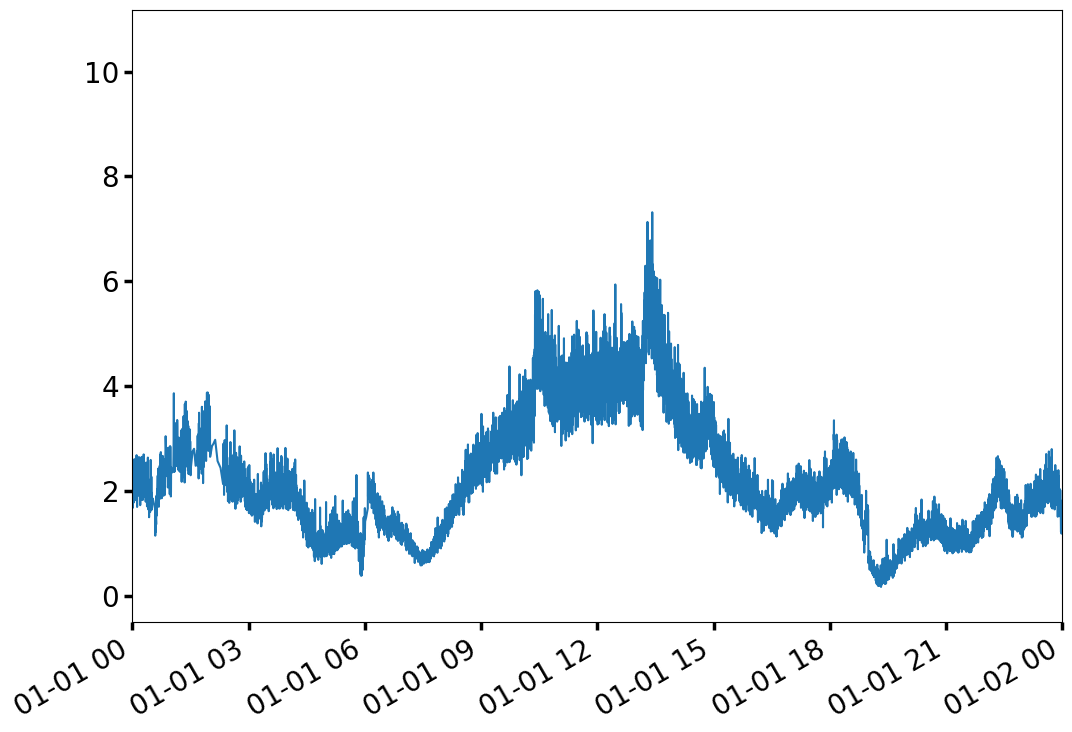

In [26]:
data.sort_index(axis="index", inplace=True)
data.NAA.plot()
plt.xlim(datetime.datetime(2025,1,1), datetime.datetime(2025,1,2))

21400.0
24000.0
24800.0
25200.0
40750.0


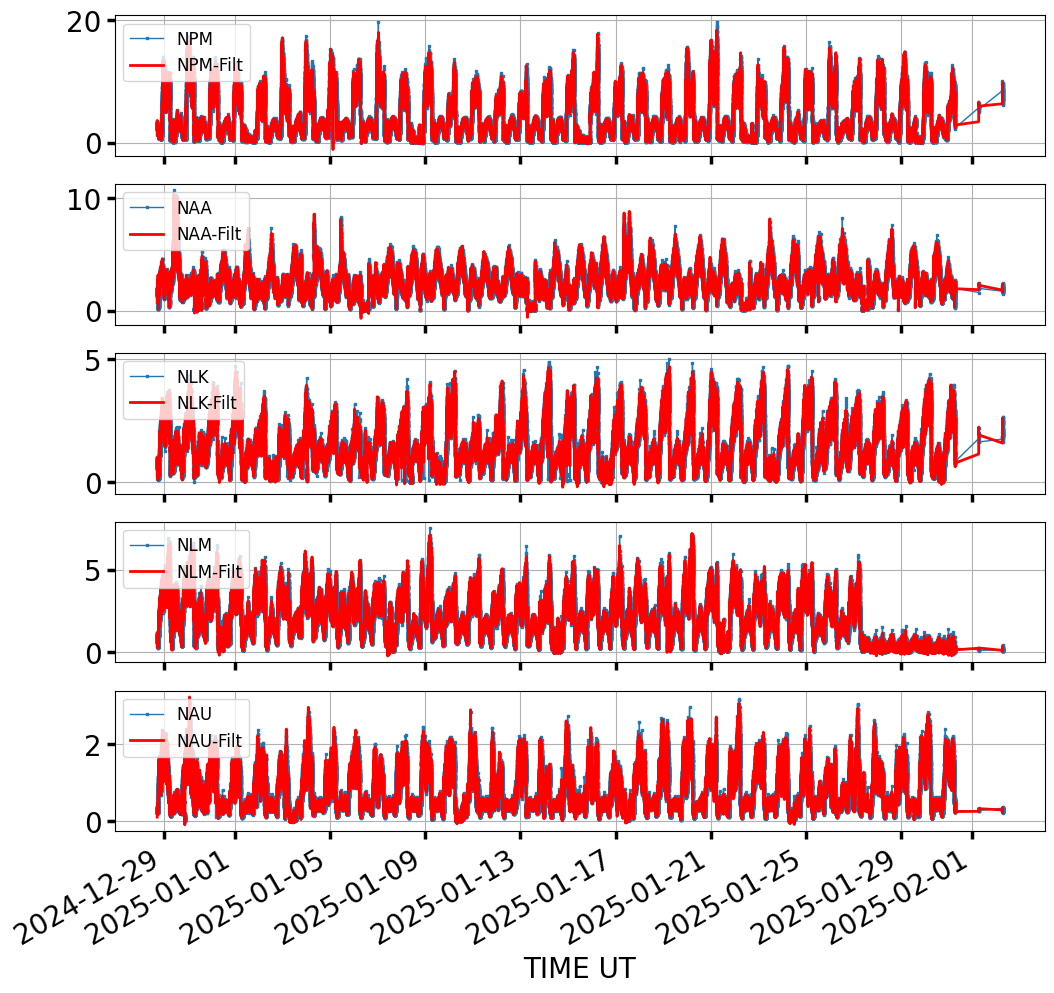

In [45]:
vlf_transmitters #= {"24kTest": 24e3,"25ktest":25e3}
n = len(vlf_transmitters)
fig, axs = plt.subplots(n,1,figsize=(12,12),sharex=True)
#axs[0].set_title(str(fft_npts_ovlp) + " npts")
COMP_FACT = 1
f0 = 24e3
bw=150



sos = signal.butter(5, 0.04, 'lp', fs=1/10, output='sos')
time_arr = data.index
for ii, vlfname in  enumerate(vlf_transmitters):
    f0 = vlf_transmitters[vlfname]
    print(f0)
    
    amp_curve = data[vlfname]
    filtered = signal.sosfilt(sos, amp_curve)
    
    axs[ii].plot(time_arr, amp_curve,label=vlfname, linewidth=1, marker="s", markersize=2)
    axs[ii].plot(time_arr, filtered,label=vlfname+"-Filt", linewidth=2, color="red" )
    axs[ii].legend(fontsize=12, loc="upper left")
    axs[ii].grid()
    
    data[vlfname+"-FILT"] = filtered
    
#axs[-1].set_xlim(left= datetime.datetime(2023,10,13,0,0), right= datetime.datetime(2023,10,13,1,))
axs[-1].set_xlabel("TIME UT")
fig.autofmt_xdate()
#fig.suptitle("PIURA VLF 2024")

In [46]:

df = pd.DataFrame(nbdata,index=time_arr)
df

,NPM,NAA,NLK,NLM,NAU,NPM-FILT,NAA-FILT,NLK-FILT,NLM-FILT,NAU-FILT
2024-12-28 17:29:09,1.323540,2.789310,1.232200,2.375511,1.122843,8.603422e-13,1.813138e-12,8.009686e-13,1.544156e-12,7.298830e-13
2024-12-28 17:29:18,1.240974,2.243253,0.929637,2.477686,1.126240,1.732243e-11,3.626452e-11,1.598028e-11,3.125334e-11,1.474346e-11
2024-12-28 17:29:28,1.150930,2.566806,0.829360,2.296119,1.344157,1.740688e-10,3.622924e-10,1.590823e-10,3.156954e-10,1.488291e-10
2024-12-28 17:29:38,1.019458,2.231883,0.983248,2.442308,1.064832,1.169216e-09,2.421527e-09,1.058613e-09,2.131658e-09,1.005398e-09
2024-12-28 17:29:47,1.142034,2.701575,1.038949,2.141605,1.417858,5.931899e-09,1.223648e-08,5.322481e-09,1.087219e-08,5.134883e-09
...,...,...,...,...,...,...,...,...,...,...
2025-02-02 06:33:58,2.872202,1.669691,0.576586,0.754752,0.258526,1.856479e+00,2.132861e+00,8.144665e-01,1.494910e+00,7.783085e-01
2025-02-02 06:34:08,2.654365,1.684894,0.683794,0.678977,0.232595,1.867203e+00,2.128370e+00,8.120860e-01,1.484696e+00,7.733366e-01
2025-02-02 06:34:18,2.099417,1.900309,0.644981,0.621103,0.261073,1.877378e+00,2.123282e+00,8.093082e-01,1.474984e+00,7.687843e-01
2025-02-02 06:34:27,1.505931,2.817113,0.769943,2.207965,1.071065,1.887104e+00,2.117547e+00,8.061504e-01,1.465653e+00,7.645460e-01


Text(0.5, 0, 'Time (UTC)')

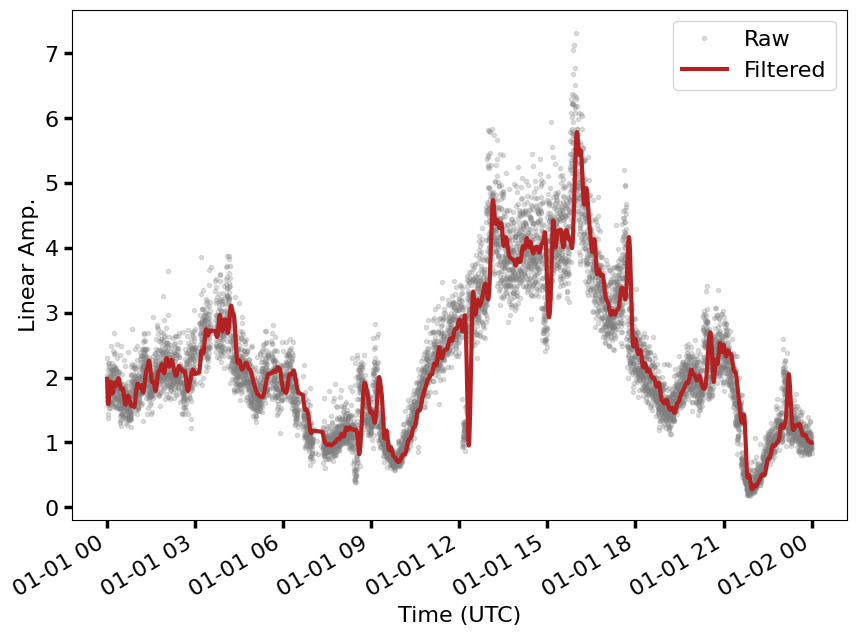

In [147]:
tx = "NAA"
ti = datetime.datetime(2025,1,1)
tf = datetime.datetime(2025,1,2)
df.loc[ti:tf , tx].plot(color="gray", marker=".", 
                                                                             lw=0, alpha=0.25, label="Raw")
                                                                                                           
df.loc[datetime.datetime(2025,1,1):datetime.datetime(2025,1,2) , f"{tx}-FILT"].plot(color="firebrick", lw=3, 
                                                                                  label="Filtered")
plt.legend()
plt.ylabel(" Linear Amp. ")
plt.xlabel("Time (UTC)")

In [59]:
df_db = df.apply(lambda x: 20*np.log10(x))

/home/aldo/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [1]:
tx = "NAA"
ti = datetime.datetime(2025,1,1)
tf = datetime.datetime(2025,1,2)
df_db.loc[ti:tf , tx].plot(color="gray", marker=".", 
                                                                             lw=0, alpha=0.25, label="Raw")
                                                                                                           
df_db.loc[datetime.datetime(2025,1,1):datetime.datetime(2025,1,2) , f"{tx}-FILT"].plot(color="firebrick", lw=3, 
                                                                                  label="Filtered")
plt.legend()
plt.ylabel(" Amp. dB ")
plt.xlabel("Time (UTC)")

NameError: name 'datetime' is not defined

## Guardar la data  de transmisoras(narrowband)

In [155]:
# alistamos la data en un dataframe
outdata = data


outdata.tail()

,NPM,NAA,NLK,NLM,NAU,NPM-FILT,NAA-FILT,NLK-FILT,NLM-FILT,NAU-FILT
2025-02-02 06:33:58,7.657877,1.862685,2.453454,0.096239,0.317613,6.851042,1.998417,2.555558,0.106086,0.303429
2025-02-02 06:34:08,6.289041,2.405478,1.639732,0.162761,0.279381,7.302062,2.167174,2.252748,0.149805,0.295756
2025-02-02 06:34:18,7.246017,1.606702,2.472915,0.159731,0.299608,6.727026,2.037162,1.774336,0.140598,0.294468
2025-02-02 06:34:27,7.167607,1.801642,2.553332,0.081922,0.233904,6.831611,1.740104,2.501240,0.147767,0.267806
2025-02-02 06:34:37,6.365127,2.062064,1.905122,0.107006,0.241273,7.399661,1.753121,2.563404,0.085183,0.238273


In [157]:
data.to_csv(f"{resfolder}/PIU_AMPCURVES_{data.index[0]}-to-{data.index[-1]}.csv")
print("GUARDADO")

GUARDADO


## Solar X rays

In [89]:
import sxrf_download

In [90]:
OUTPUT_PATH = None #f"{resfolder}/xrayflux"
d_i = "2024-12-28 00:00"#datetime.datetime(2023, 11,2) #1st day
d_f = "2025-02-01 00:00"#datetime.datetime(2023, 11,15)  #last day


#dates = [d_i+datetime.timedelta(days=int(d)) for d in range(nd.days+1)]

In [43]:
!mkdir -p $OUTPUT_PATH

In [122]:
# lista de dias de lso que queremos datos (solar x-ray flux )
periodo = [datetime.datetime(2024,12,27)+datetime.timedelta(days=k) for k in range(45)]
xr = sxrf_download.download_xrayfluxdata(periodo)

URL: https://climaespacial.conida.gob.pe/GOES/DatosClimaEspacial/AnalizarDatoXrays_Recolectar.php?index=6&fecha={}

/home/aldo/jupyter/notebooks/code/sxrf_download.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_xr = pd.concat([df_xr, dfcsv])


/home/aldo/jupyter/notebooks/code/sxrf_download.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_xr = pd.concat([df_xr, dfcsv])


/home/aldo/jupyter/notebooks/code/sxrf_download.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_xr = pd.concat([df_xr, dfcsv])


Completed.


/home/aldo/jupyter/notebooks/code/sxrf_download.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_xr = pd.concat([df_xr, dfcsv])


In [124]:
xr.set_index("DateTime", inplace=True)

In [125]:
xr.head()

,GOES-18 long,GOES-18 short,GOES-16 long,GOES-16 short,GOES-17 long,GOES-17 short
DateTime,,,,,,
2024-12-27 00:00:00,0.000004,1.260000e-07,0.000004,1.400000e-07,NaN,NaN
2024-12-27 00:01:00,0.000003,8.570000e-08,NaN,NaN,NaN,NaN
2024-12-27 00:02:00,0.000003,6.110000e-08,NaN,NaN,NaN,NaN
2024-12-27 00:03:00,0.000003,5.600000e-08,NaN,NaN,NaN,NaN
2024-12-27 00:04:00,0.000003,7.520000e-08,0.000003,9.270000e-08,NaN,NaN


Text(0.5, 1.0, 'NAA-PIU')

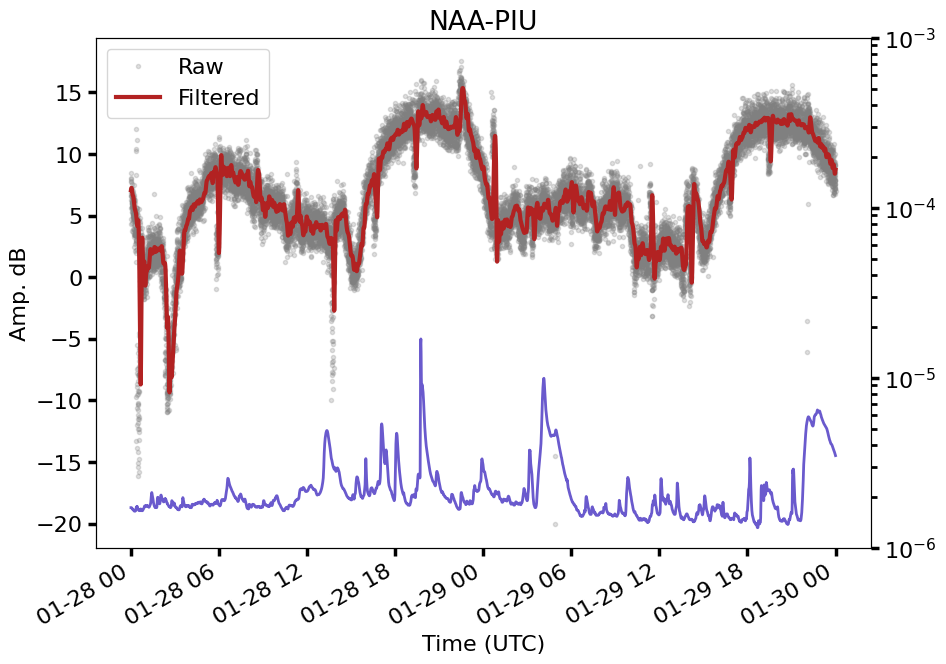

In [166]:
tx = "NAA"
ti = datetime.datetime(2025,1,28)
tf = datetime.datetime(2025,1,30)

fig, ax = plt.subplots()
plt.plot(df_db.loc[ti:tf , tx],color="gray", marker=".", 
                            lw=0, alpha=0.25, label="Raw",)

plt.plot(df_db.loc[ti:tf , f"{tx}-FILT"], color="firebrick", lw=3, 
                                      label="Filtered",)
plt.legend()
plt.ylabel(" Amp. dB ")
plt.xlabel("Time (UTC)")

# twin x plot for SXRF 
ax2 = ax.twinx()
ax2.plot(xr.loc[ti:tf, "GOES-18 long"],color="slateblue", lw=2)
ax2.set_yscale("log")
ax2.set_ylim(1e-6, 1e-3)
fig.autofmt_xdate()
plt.title(f"{tx}-PIU")

Text(0.5, 1.0, 'NAA-PIU')

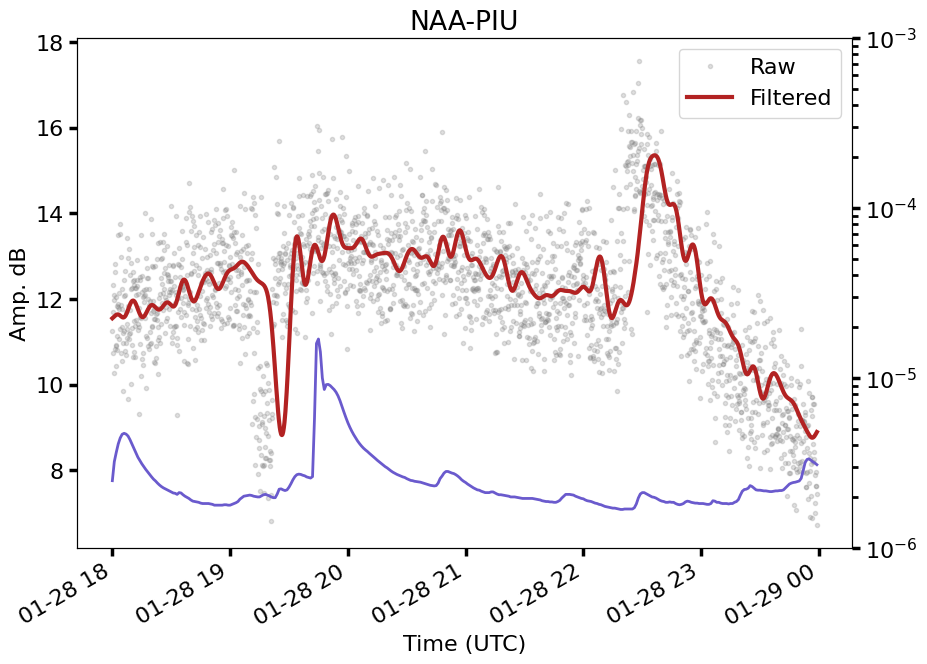

In [167]:
tx = "NAA"
ti = datetime.datetime(2025,1,28,18)
tf = datetime.datetime(2025,1,28,23,59 )

fig, ax = plt.subplots()
plt.plot(df_db.loc[ti:tf , tx],color="gray", marker=".", 
                            lw=0, alpha=0.25, label="Raw",)

plt.plot(df_db.loc[ti:tf , f"{tx}-FILT"], color="firebrick", lw=3, 
                                      label="Filtered",)
plt.legend()
plt.ylabel(" Amp. dB ")
plt.xlabel("Time (UTC)")

# twin x plot for SXRF 
ax2 = ax.twinx()
ax2.plot(xr.loc[ti:tf, "GOES-18 long"],color="slateblue", lw=2)
ax2.set_yscale("log")
ax2.set_ylim(1e-6, 1e-3)
fig.autofmt_xdate()
plt.title(f"{tx}-PIU")

In [158]:
df_db.index += datetime.timedelta(hours=5)
df.index += datetime.timedelta(hours=5)

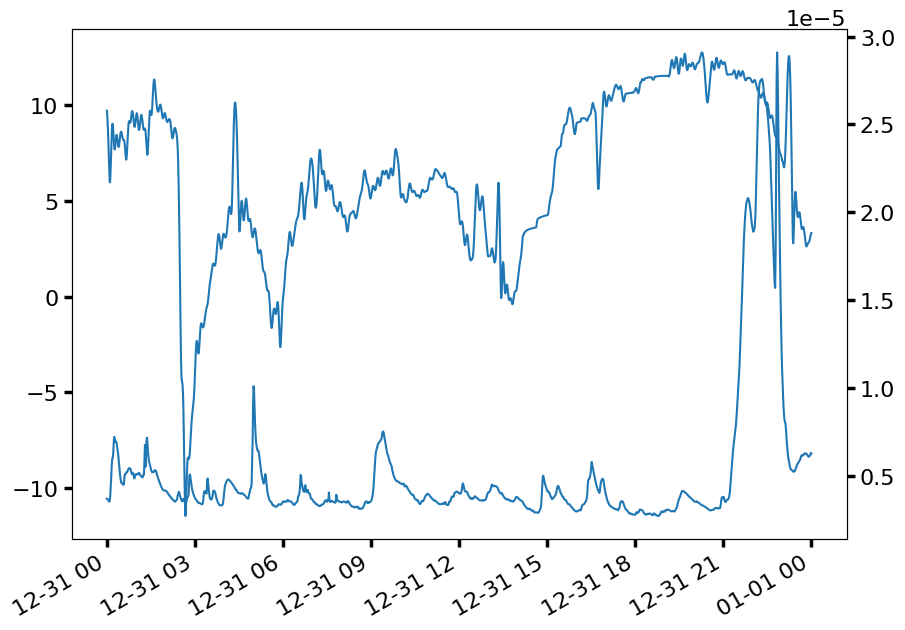

In [160]:
ax = plt.gca()
df_db.loc[datetime.datetime(2024,12,31):datetime.datetime(2025,1,1), "NAA-FILT"].plot()
ax2 = ax.twinx()
ax2.plot(xr.loc[datetime.datetime(2024,12,31):datetime.datetime(2025,1,1), "GOES-18 long"])

In [146]:
df_db.astype(

NPM         float64
NAA         float64
NLK         float64
NLM         float64
NAU         float64
NPM-FILT    float64
NAA-FILT    float64
NLK-FILT    float64
NLM-FILT    float64
NAU-FILT    float64
dtype: object